In [1]:
#import statements
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer,RobustScaler,MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from statsmodels.formula.api import ols


import env
import get_function as gf

**Aquire**

In [2]:
# Import from zillow
df = gf.get_zillow_data()

In [3]:
df.head()

,parcelid,logerror,transactiondate,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,12177905,-0.103410,2017-01-01,2288172,12177905,NaN,None,None,3.0,4.0,...,NaN,None,108918.0,145143.0,2016.0,36225.0,1777.51,None,NaN,6.037300e+13
1,12095076,-0.001011,2017-01-01,781532,12095076,1.0,None,None,3.0,4.0,...,NaN,None,276684.0,773303.0,2016.0,496619.0,9516.26,None,NaN,6.037461e+13
2,12069064,0.101723,2017-01-01,870991,12069064,NaN,None,None,1.0,2.0,...,NaN,None,18890.0,218552.0,2016.0,199662.0,2366.08,None,NaN,6.037302e+13
3,12790562,-0.040966,2017-01-02,1246926,12790562,NaN,None,None,3.0,4.0,...,NaN,None,177527.0,220583.0,2016.0,43056.0,3104.19,None,NaN,6.037500e+13
4,11104527,0.005963,2017-01-02,1639362,11104527,1.0,None,None,3.0,4.0,...,NaN,None,271715.0,430108.0,2016.0,158393.0,6103.36,None,NaN,6.037920e+13


In [4]:
df.shape

(33701, 62)

**Prepare**

In [5]:
# dropp columns with less than 60% of data non-null and rows with more than 75% of data non-null
df = gf.handle_missing_values(df, prop_required_column = .6, prop_required_row = .75)

In [6]:
df.isnull().sum()

parcelid                          0
logerror                          0
transactiondate                   0
id                                0
parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
buildingqualitytypeid           127
calculatedbathnbr                 0
calculatedfinishedsquarefeet      0
finishedsquarefeet12              0
fips                              0
fullbathcnt                       0
heatingorsystemtypeid           536
latitude                          0
longitude                         0
lotsizesquarefeet               304
propertycountylandusecode         0
propertylandusetypeid             0
propertyzoningdesc               68
rawcensustractandblock            0
regionidcity                    694
regionidcounty                    0
regionidzip                      12
roomcnt                           0
unitcnt                           0
yearbuilt                         7
structuretaxvaluedollarcnt  

In [7]:
df.shape

(33701, 33)

In [8]:
# removing unnessesery columns
df = gf.remove_columns(df, ['roomcnt','assessmentyear','unitcnt','regionidzip','regionidcounty','propertylandusetypeid','propertycountylandusecode','fullbathcnt','calculatedbathnbr','rawcensustractandblock','finishedsquarefeet12','parcelid','transactiondate','id','regionidcity','buildingqualitytypeid','heatingorsystemtypeid','propertyzoningdesc','censustractandblock'])

In [9]:
df.isnull().sum()

logerror                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet      0
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               304
yearbuilt                         7
structuretaxvaluedollarcnt       60
taxvaluedollarcnt                 0
landtaxvaluedollarcnt             0
taxamount                         4
dtype: int64

In [10]:
df.shape

(33701, 13)

In [11]:
df = df.rename(columns={'lotsizesquarefeet':'lot_square_feet','calculatedfinishedsquarefeet':'home_square_feet', 'logerror': 'target','bathroomcnt': 'bathroom', 'bedroomcnt': 'bedroom','structuretaxvaluedollarcnt':'structure_value','taxvaluedollarcnt': 'total_value','landtaxvaluedollarcnt':'land_value','taxamoun':'tax_amount','taxamount':'tax_amount','yearbuilt':'year_built'})

In [12]:
# Covert year built into age years

df['age']= 2017 - df.year_built

In [13]:
# Drop year built because we added age column

df.drop(columns='year_built',inplace=True)

In [14]:
# Delete rows where tax value amount does not equal land value + structure value

np.where(df.total_value - (df.land_value + df.structure_value) != 0)

(array([  397,   875,   878,   940,   959,  1203,  1278,  1324,  1726,
         1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
         5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
        12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
        19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
        22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
        31708, 32148, 32171, 32679, 33018, 33032]),)

In [15]:
df.loc[31024]

# 397, 878,   940,   959,  1203,  1278,  1324,  1726,
# 1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
# 5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
# 12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
# 19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
# 22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
# 31708, 32148, 32171, 32679, 33018, 33032]

target              8.249599e-02
bathroom            1.000000e+00
bedroom             3.000000e+00
home_square_feet    1.460000e+03
fips                6.037000e+03
latitude            3.411261e+07
longitude          -1.180782e+08
lot_square_feet     9.099000e+03
structure_value              NaN
total_value         7.898640e+05
land_value          7.898640e+05
tax_amount          9.132300e+03
age                 6.200000e+01
Name: 31024, dtype: float64

In [16]:
df.drop([397,   875,   878,   940,   959,  1203,  1278,  1324,  1726,
         1750,  1927,  2370,  4472,  4703,  5251,  5463,  5514,  5723,
         5783,  6108,  6887,  7005,  8739,  9386, 10622, 11406, 11585,
        12340, 12850, 13048, 13655, 13739, 14337, 14865, 15060, 18902,
        19494, 19762, 20312, 20614, 20917, 21217, 21285, 21661, 22036,
        22183, 22185, 23676, 25773, 26889, 27696, 28695, 31024, 31553,
        31708, 32148, 32171, 32679, 33018, 33032],axis=0,inplace=True)

In [17]:
df.isnull().sum()

target                0
bathroom              0
bedroom               0
home_square_feet      0
fips                  0
latitude              0
longitude             0
lot_square_feet     291
structure_value       0
total_value           0
land_value            0
tax_amount            3
age                   7
dtype: int64

In [18]:
# Split data (train & test)

train, test = gf.split_my_data(df, .80, 123)

In [19]:
# impute lot_square_feet,structure_value, and tax_amount for the mean

train = gf.imputer_9000(train,['lot_square_feet','tax_amount', 'age'],'mean')
test = gf.imputer_9000(test,['lot_square_feet','tax_amount', 'age'],'mean')

In [20]:
train['home_value_square_footage'] = train.structure_value/train.home_square_feet
train['land_value_square_footage'] = train.land_value/train.lot_square_feet

test['home_value_square_footage'] = test.structure_value/test.home_square_feet
test['land_value_square_footage'] = test.land_value/test.lot_square_feet

In [21]:
train.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [22]:
test.isnull().sum()

target                       0
bathroom                     0
bedroom                      0
home_square_feet             0
fips                         0
latitude                     0
longitude                    0
lot_square_feet              0
structure_value              0
total_value                  0
land_value                   0
tax_amount                   0
age                          0
home_value_square_footage    0
land_value_square_footage    0
dtype: int64

In [23]:
train.head()

,target,bathroom,bedroom,home_square_feet,fips,latitude,longitude,lot_square_feet,structure_value,total_value,land_value,tax_amount,age,home_value_square_footage,land_value_square_footage
33257,0.005565,3.0,4.0,1673.0,6037.0,33985663.0,-118229161.0,3000.0,126192.0,227194.0,101002.0,3505.67,18.0,75.428571,33.667333
8306,0.452906,1.0,3.0,950.0,6037.0,33941666.0,-118235240.0,3251.0,116496.0,191571.0,75075.0,2495.60,52.0,122.627368,23.092894
25859,0.020907,2.0,3.0,1256.0,6037.0,34209673.0,-118628052.0,7525.0,46269.0,84214.0,37945.0,1137.12,56.0,36.838376,5.042525
30676,0.012864,2.0,3.0,1984.0,6037.0,34129558.0,-117719482.0,15368.0,242729.0,683452.0,440723.0,9630.60,40.0,122.343246,28.677967
30916,0.007597,2.0,4.0,2016.0,6037.0,34013213.0,-117863106.0,7595.0,179535.0,223522.0,43987.0,2839.42,40.0,89.055060,5.791573


In [24]:
test.head()

,target,bathroom,bedroom,home_square_feet,fips,latitude,longitude,lot_square_feet,structure_value,total_value,land_value,tax_amount,age,home_value_square_footage,land_value_square_footage
33106,-0.027917,3.0,5.0,3083.0,6037.0,34671833.0,-118084245.0,11565.0,250104.0,309853.0,59749.0,4751.76,4.0,81.123581,5.166364
535,0.008490,1.0,3.0,1115.0,6037.0,33978427.0,-118063427.0,5697.0,96432.0,292670.0,196238.0,3732.85,67.0,86.486099,34.445849
6513,-0.034321,3.0,6.0,2176.0,6037.0,34032118.0,-118303539.0,7184.0,159154.0,424413.0,265259.0,5212.80,95.0,73.140625,36.923580
25153,-0.114455,2.0,2.0,1385.0,6037.0,34010163.0,-118309306.0,5876.0,29632.0,71701.0,42069.0,960.64,105.0,21.394946,7.159462
14729,0.070176,2.0,2.0,2209.0,6037.0,34043071.0,-118493656.0,9041.0,72049.0,228604.0,156555.0,3190.31,91.0,32.616116,17.316115


In [25]:
# Scaling dataframe in two ways

In [26]:
# Scale age, latitude, and longitude using MinMax scaler - why (to presrve distance better)

train = gf.scaler_min_max(train, ['age', 'latitude', 'longitude'])
test = gf.scaler_min_max(test, ['age', 'latitude', 'longitude'])

In [27]:
# Scale bathroom, bedroom, home_square_feet, lot_square_feet, structure_value, total_value, land_value, tax_amount using uniform scaler

# Scale columns using Uniform scaler (to smooth out the distribution and handle outliers)

train = gf.uniform_scaler(train,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])
test = gf.uniform_scaler(test,['bathroom', 'bedroom', 'home_square_feet', 'lot_square_feet', 'structure_value', 'total_value', 'land_value', 'tax_amount'])

In [28]:
train[train.target > 0].mean()

target                          0.081899
fips                         6037.004416
home_value_square_footage      90.518032
land_value_square_footage      40.968673
age                             0.418692
latitude                        0.526978
longitude                       0.524213
bathroom                        0.488470
bedroom                         0.515254
home_square_feet                0.518310
lot_square_feet                 0.506307
structure_value                 0.507789
total_value                     0.507428
land_value                      0.505919
tax_amount                      0.506962
dtype: float64

In [29]:
train[train.target < 0].mean()

target                         -0.068046
fips                         6037.003676
home_value_square_footage      90.428961
land_value_square_footage      39.519948
age                             0.433634
latitude                        0.530344
longitude                       0.528297
bathroom                        0.448830
bedroom                         0.481751
home_square_feet                0.477126
lot_square_feet                 0.491834
structure_value                 0.490066
total_value                     0.490615
land_value                      0.492507
tax_amount                      0.491223
dtype: float64

In [30]:
train.target.mean()

0.015217332551863352

In [31]:
train[train.target > 0].count()

target                       14944
fips                         14944
home_value_square_footage    14944
land_value_square_footage    14944
age                          14944
latitude                     14944
longitude                    14944
bathroom                     14944
bedroom                      14944
home_square_feet             14944
lot_square_feet              14944
structure_value              14944
total_value                  14944
land_value                   14944
tax_amount                   14944
dtype: int64

In [32]:
train[train.target < 0].count()

target                       11968
fips                         11968
home_value_square_footage    11968
land_value_square_footage    11968
age                          11968
latitude                     11968
longitude                    11968
bathroom                     11968
bedroom                      11968
home_square_feet             11968
lot_square_feet              11968
structure_value              11968
total_value                  11968
land_value                   11968
tax_amount                   11968
dtype: int64

In [33]:
train[train.target > 0].count() /(train[train.target > 0].count() + train[train.target < 0].count())

target                       0.555291
fips                         0.555291
home_value_square_footage    0.555291
land_value_square_footage    0.555291
age                          0.555291
latitude                     0.555291
longitude                    0.555291
bathroom                     0.555291
bedroom                      0.555291
home_square_feet             0.555291
lot_square_feet              0.555291
structure_value              0.555291
total_value                  0.555291
land_value                   0.555291
tax_amount                   0.555291
dtype: float64

Differinces in over and underestimation

over mean = .081

over %56

under mean = -.0680

under %44


In [34]:
stats.ttest_ind(train[train.target < 0].mean(),train[train.target > 0].mean())

Ttest_indResult(statistic=-0.00021801657840273504, pvalue=0.9998275938430903)

There is no significant differince in the overestimations and underestimations

In [35]:
train['absolute_target']= train.target.abs()

In [36]:
# plt.figure(figsize=(12,12))
# sns.heatmap(train.corr(), cmap='RdYlBu', annot=True, center=0)

In [37]:
# plt.figure(figsize=(22,22))
# sns.pairplot(train)
# plt.show()

In [38]:
# plt.figure(figsize=(22,22))
# sns.pairplot(train[['target', 'home_value_square_footage','land_value_square_footage']])
# plt.show()

home_value_square_footage and land_value_square_foortage show a correlation with logerror 

Going to try correlating home_value_square_footage and land_value_square_foortage  with longitude and latitude and see if a useful patrern emerges

   k           sse
0  1  1.065533e+08
1  2  5.687185e+07
2  3  3.234598e+07
3  4  2.060199e+07
4  5  1.331423e+07
5  6  9.439711e+06
6  7  7.102802e+06
7  8  5.408580e+06
8  9  4.393792e+06


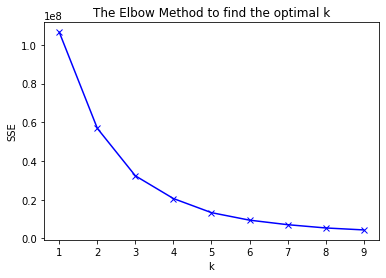

In [39]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['home_value_square_footage', 'longitude', 'latitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

We are going to look at models where k = 3, 4, or 5

[[362.36330027   0.38850164   0.47434598]
 [129.11691225   0.49842454   0.53627872]
 [ 58.02583499   0.54725506   0.52568753]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0          570.0  0.001281  0.224293 -2.175696 -0.034279  0.017214  0.064267   
1         9830.0  0.009099  0.158652 -1.738639 -0.028781  0.004939  0.038105   
2        16512.0  0.019341  0.171813 -4.655420 -0.029242  0.006748  0.043341   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        2.069414    570.0  6037.000000  ...   0.990114  1.000000   
1        5.262999   9830.0  6037.002238  ...   0.878041  0.993188   
2        3.100913  16512.0  6037.005329  ...   0.546021  0.991486   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0                 570.0  0.110170  0.195321  0.000013  0.024298  0.052839   
1                9830.0  0.068315  0.143478  0.000007  0.014974  0.034018   
2               16512.0  0.078970  0.153809  0.000003  0.015828  0.036554   

                             
              75%       max  
cluster                      
0        0.110816  2.175696  
1        0.071147  5.262999  
2        0.081906  4.655420  

[3 rows x 128 columns]

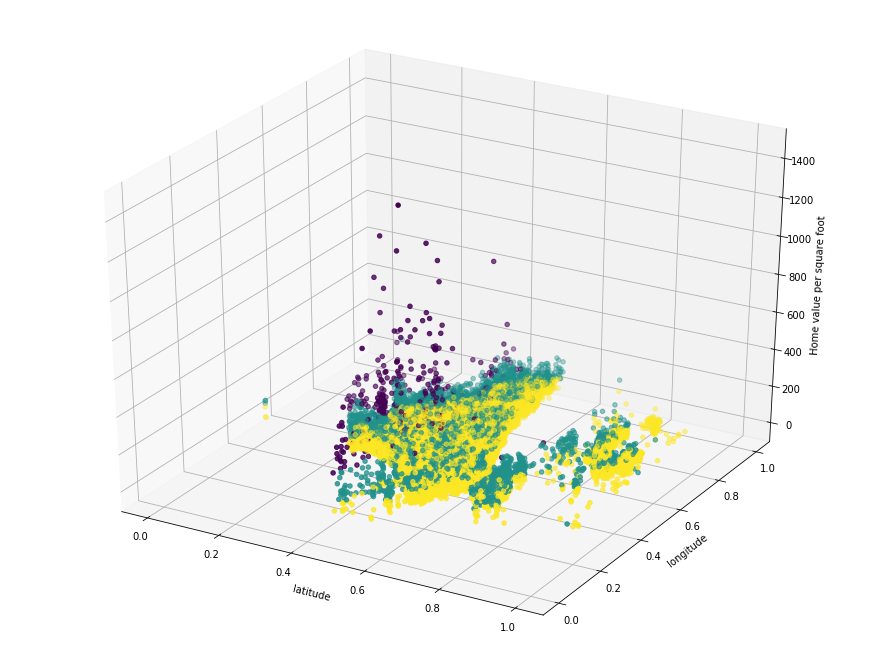

In [40]:
X = train[['home_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.home_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='Home value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[1.07149067e+02 5.21836383e-01 5.46833373e-01]
 [2.14325654e+02 4.40919591e-01 4.98681091e-01]
 [4.87072545e+01 5.45598392e-01 5.15233392e-01]
 [5.57666171e+02 3.58442646e-01 4.70481046e-01]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        12499.0  0.011353  0.144123 -1.738639 -0.026900  0.004777  0.036747   
1         1943.0  0.004683  0.193471 -1.702338 -0.036929  0.007591  0.050640   
2        12326.0  0.021066  0.183261 -4.655420 -0.030393  0.007571  0.046576   
3          144.0 -0.007795  0.345377 -2.175696 -0.051755  0.025309  0.075334   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.394544  12499.0  6037.003520  ...   0.807144  0.993188   
1        5.262999   1943.0  6037.011323  ...   0.971803  0.997639   
2        3.100913  12326.0  6037.003570  ...   0.453238  0.991486   
3        2.069414    144.0  6037.000000  ...   0.991109  1.000000   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               12499.0  0.064372  0.129446  0.000006  0.013953  0.032338   
1                1943.0  0.085619  0.173547  0.000007  0.019337  0.044000   
2               12326.0  0.084701  0.163871  0.000003  0.016832  0.038480   
3                 144.0  0.161941  0.304858  0.000429  0.033916  0.065532   

                             
              75%       max  
cluster                      
0        0.067597  3.394544  
1        0.094886  5.262999  
2        0.087727  4.655420  
3        0.143942  2.175696  

[4 rows x 128 columns]

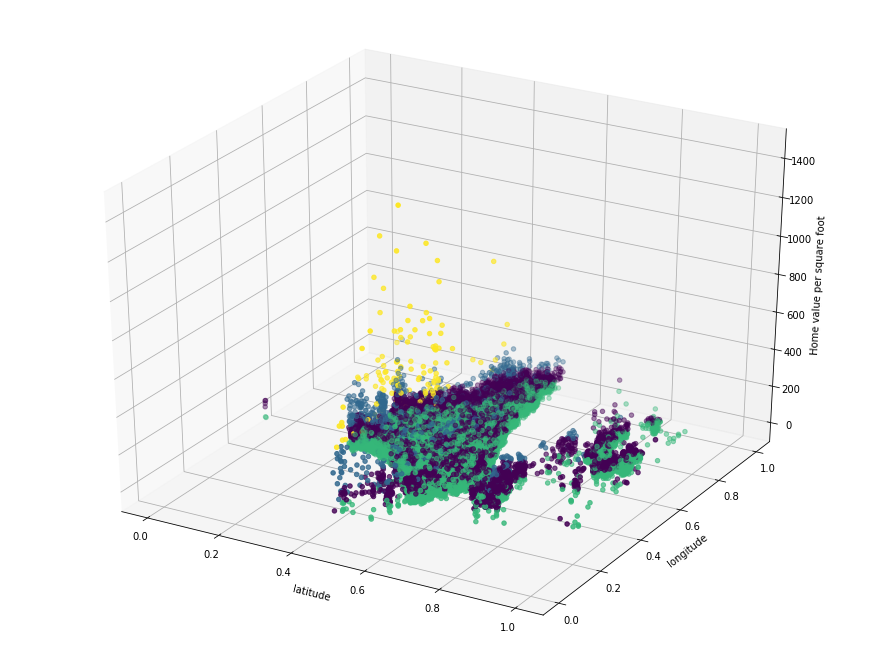

In [41]:
X = train[['home_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.home_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='Home value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[9.25621178e+01 5.39767979e-01 5.48903759e-01]
 [4.19716067e+01 5.41465603e-01 5.06968329e-01]
 [3.09151894e+02 3.96577336e-01 4.76834956e-01]
 [1.56546788e+02 4.69712072e-01 5.25190211e-01]
 [7.40214451e+02 3.64830524e-01 4.78387842e-01]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        12480.0  0.013673  0.144945 -1.623253 -0.026370  0.005057  0.037118   
1         9626.0  0.022551  0.191653 -4.655420 -0.032103  0.007711  0.048295   
2          603.0  0.004751  0.222421 -2.175696 -0.034846  0.016450  0.064806   
3         4147.0  0.005391  0.166122 -1.738639 -0.031299  0.005566  0.041665   
4           56.0 -0.060786  0.231311 -1.019561 -0.056040  0.015172  0.047437   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.394544  12480.0  6037.003526  ...   0.738635  0.993188   
1        3.100913   9626.0  6037.004571  ...   0.363510  0.991486   
2        2.069414    603.0  6037.000000  ...   0.989905  1.000000   
3        5.262999   4147.0  6037.005305  ...   0.929728  0.992252   
4        0.244792     56.0  6037.000000  ...   0.991389  0.999529   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               12480.0  0.064669  0.130436  0.000006  0.014082  0.032174   
1                9626.0  0.089142  0.171150  0.000003  0.017428  0.040355   
2                 603.0  0.106900  0.195056  0.000011  0.024044  0.052920   
3                4147.0  0.072661  0.149481  0.000007  0.015844  0.037056   
4                  56.0  0.131206  0.199346  0.000429  0.030359  0.052918   

                             
              75%       max  
cluster                      
0        0.067958  3.394544  
1        0.092117  4.655420  
2        0.107876  2.175696  
3        0.077508  5.262999  
4        0.134748  1.019561  

[5 rows x 128 columns]

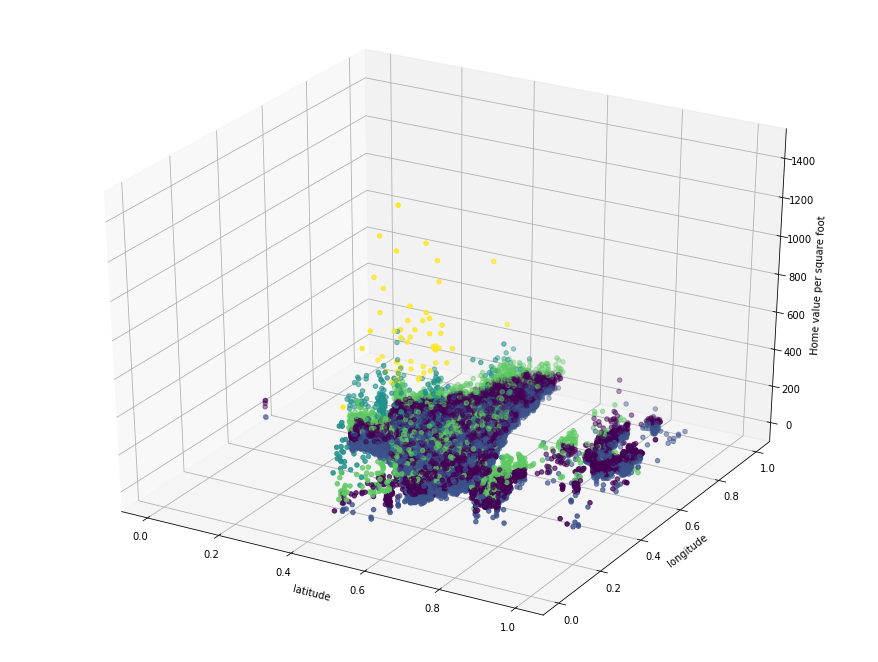

In [42]:
X = train[['home_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.home_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='Home value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

   k           sse
0  1  1.090859e+08
1  2  5.551515e+07
2  3  3.222181e+07
3  4  1.906330e+07
4  5  1.274763e+07
5  6  8.904909e+06
6  7  6.585978e+06
7  8  4.888484e+06
8  9  3.824216e+06


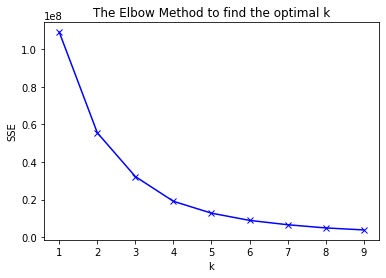

In [43]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train[['land_value_square_footage', 'longitude', 'latitude']])

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

[[2.66143040e+01 5.35541235e-01 5.35928452e-01]
 [6.85817789e+02 3.80534051e-01 4.05071725e-01]
 [1.54705953e+02 4.34049109e-01 4.56787427e-01]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        24446.0  0.016480  0.161457 -2.331727 -0.028716  0.005928  0.041248   
1           99.0  0.022386  0.197343 -0.696273 -0.037158  0.019148  0.068309   
2         2367.0  0.001879  0.227688 -4.655420 -0.036298  0.010121  0.049124   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.394544  24446.0  6037.002700  ...   0.687388  0.994397   
1        1.310249     99.0  6037.222222  ...   0.990442  1.000000   
2        5.262999   2367.0  6037.009294  ...   0.963650  0.999529   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               24446.0  0.074447  0.144213  0.000003  0.015211  0.035040   
1                  99.0  0.104852  0.168358  0.000161  0.028669  0.063555   
2                2367.0  0.087858  0.210055  0.000007  0.019652  0.043344   

                             
              75%       max  
cluster                      
0        0.077266  3.394544  
1        0.110133  1.310249  
2        0.088109  5.262999  

[3 rows x 128 columns]

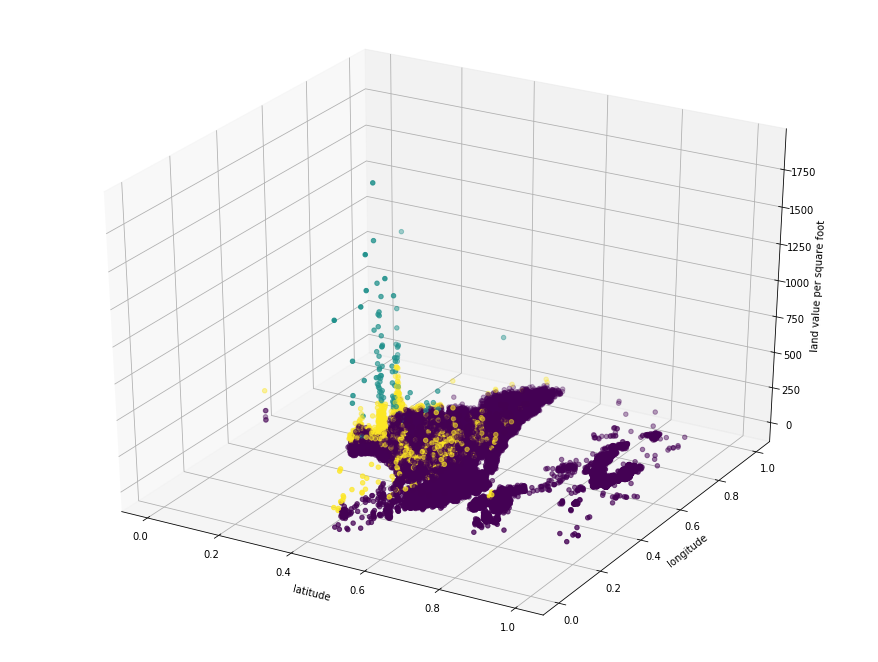

In [44]:
X = train[['land_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.land_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='land value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[1.76857322e+01 5.42379172e-01 5.51687157e-01]
 [2.52708676e+02 4.05271974e-01 4.47797836e-01]
 [7.82621757e+01 4.91272671e-01 4.66969976e-01]
 [9.01535908e+02 3.44311632e-01 3.99222303e-01]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        19777.0  0.018363  0.162770 -2.271428 -0.028841  0.006054  0.041704   
1          777.0  0.003660  0.248899 -2.175696 -0.032466  0.014583  0.054835   
2         6310.0  0.006733  0.173664 -4.655420 -0.030372  0.005909  0.041140   
3           48.0  0.021690  0.155048 -0.430161 -0.046968  0.018875  0.072510   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.394544  19777.0  6037.003337  ...   0.582781  0.994397   
1        5.262999    777.0  6037.000000  ...   0.982438  0.999529   
2        3.175688   6310.0  6037.003487  ...   0.888638  0.997408   
3        0.664921     48.0  6037.458333  ...   0.991219  1.000000   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               19777.0  0.075847  0.145184  0.000003  0.015275  0.035266   
1                 777.0  0.090178  0.231995  0.000034  0.021495  0.045990   
2                6310.0  0.073440  0.157512  0.000007  0.016013  0.036350   
3                  48.0  0.099630  0.119929  0.006578  0.034340  0.067854   

                             
              75%       max  
cluster                      
0        0.078777  3.394544  
1        0.089711  5.262999  
2        0.074861  4.655420  
3        0.118952  0.664921  

[4 rows x 128 columns]

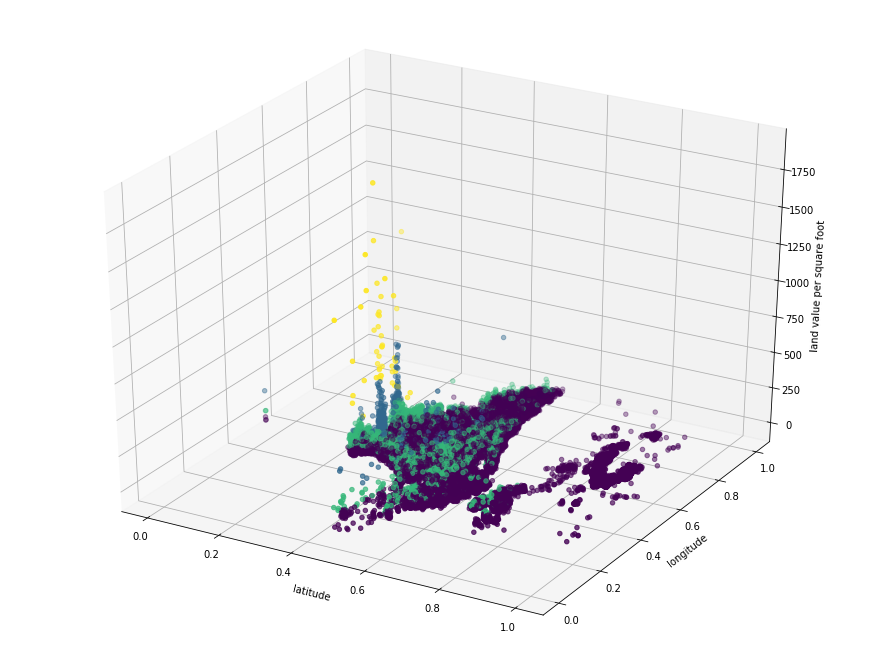

In [45]:
X = train[['land_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.land_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='land value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[5.87278623e+01 5.10216219e-01 4.76476292e-01]
 [1.36067790e+01 5.45574863e-01 5.61868092e-01]
 [1.02734110e+03 3.30690528e-01 3.99768232e-01]
 [1.52994442e+02 4.25945138e-01 4.60288897e-01]
 [3.54860515e+02 3.91724610e-01 4.29130325e-01]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0         8151.0  0.010653  0.151224 -2.331727 -0.027291  0.005931  0.039577   
1        16890.0  0.018801  0.165539 -2.271428 -0.029269  0.006010  0.042112   
2           33.0  0.008200  0.097141 -0.205920 -0.044590  0.019148  0.063555   
3         1537.0  0.002346  0.255719 -4.655420 -0.042345  0.008874  0.049075   
4          301.0  0.004209  0.212650 -2.175696 -0.025997  0.020871  0.064884   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.175688   8151.0  6037.005398  ...   0.830019  0.993300   
1        3.394544  16890.0  6037.001303  ...   0.520219  0.994397   
2        0.273869     33.0  6037.666667  ...   0.991407  1.000000   
3        5.262999   1537.0  6037.014314  ...   0.964161  0.997408   
4        1.310249    301.0  6037.000000  ...   0.988887  0.999529   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0                8151.0  0.068708  0.135133  0.000007  0.014978  0.033675   
1               16890.0  0.077179  0.147648  0.000003  0.015412  0.035714   
2                  33.0  0.073982  0.062140  0.006578  0.024019  0.060729   
3                1537.0  0.092957  0.238224  0.000034  0.021495  0.045945   
4                 301.0  0.097585  0.188900  0.000045  0.023736  0.049176   

                             
              75%       max  
cluster                      
0        0.071032  3.175688  
1        0.080478  3.394544  
2        0.088338  0.273869  
3        0.092322  5.262999  
4        0.093285  2.175696  

[5 rows x 128 columns]

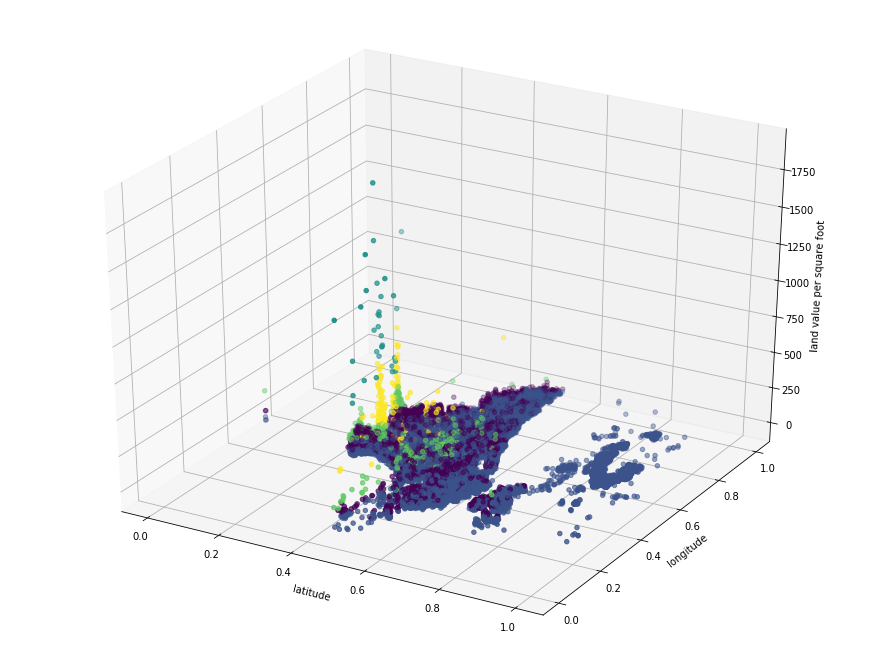

In [46]:
X = train[['land_value_square_footage', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

%matplotlib inline

fig = plt.figure(figsize=(12, 9))
ax = Axes3D(fig)

ax.scatter(X.latitude,X.longitude,X.land_value_square_footage, c=kmeans.labels_)
ax.set(xlabel='latitude', ylabel='longitude', zlabel='land value per square foot')

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

In [47]:
X = train[['land_value_square_footage', 'longitude', 'latitude','home_value_square_footage']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[1.60951958e+01 5.53298799e-01 5.39759081e-01 5.27249658e+01]
 [4.43530685e+01 5.11460925e-01 5.25863357e-01 1.13752671e+02]
 [1.70162244e+02 4.22015511e-01 4.62143316e-01 1.92608526e+02]
 [2.14712146e+02 3.60163227e-01 4.75229634e-01 5.29830826e+02]
 [8.42879633e+02 3.71535323e-01 3.90696381e-01 2.77097443e+02]]


target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        13583.0  0.021116  0.174462 -2.331727 -0.030197  0.006802  0.045230   
1        11502.0  0.010021  0.150199 -4.655420 -0.026737  0.005165  0.036518   
2         1611.0  0.005069  0.209617 -0.976064 -0.037901  0.008353  0.050773   
3          159.0 -0.009662  0.338875 -2.175696 -0.052622  0.022360  0.077859   
4           57.0  0.014240  0.157799 -0.430161 -0.054102  0.018603  0.074126   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.100913  13583.0  6037.004859  ...   0.434342  0.990766   
1        3.394544  11502.0  6037.001913  ...   0.822879  0.991486   
2        5.262999   1611.0  6037.000000  ...   0.972794  0.997639   
3        2.069414    159.0  6037.000000  ...   0.990765  0.999529   
4        0.664921     57.0  6037.385965  ...   0.991075  1.000000   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               13583.0  0.082461  0.155185  0.000003  0.016278  0.037810   
1               11502.0  0.064855  0.135844  0.000011  0.014250  0.032259   
2                1611.0  0.087237  0.190657  0.000007  0.020949  0.045990   
3                 159.0  0.162336  0.297339  0.000429  0.036243  0.065904   
4                  57.0  0.103462  0.119212  0.003005  0.034994  0.071972   

                             
              75%       max  
cluster                      
0        0.085290  3.100913  
1        0.068227  4.655420  
2        0.092183  5.262999  
3        0.146362  2.175696  
4        0.125925  0.664921  

[5 rows x 128 columns]

In [48]:
X = train[['land_value_square_footage', 'longitude', 'latitude','home_value_square_footage']]

kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[6.17075177e+01 5.15351579e-01 4.62480165e-01 8.27814269e+01]
 [1.29553040e+03 3.23582673e-01 3.94934875e-01 3.65075165e+02]
 [5.93994074e+02 3.90598022e-01 4.03416760e-01 2.58621140e+02]
 [1.35493679e+02 4.40805092e-01 4.60728800e-01 1.37284690e+02]
 [1.79392726e+01 5.62565740e-01 5.96415239e-01 8.75001602e+01]
 [1.01703686e+01 5.42922050e-01 5.10950854e-01 3.73412979e+01]
 [9.98365122e+01 4.13505421e-01 4.86946769e-01 2.86035472e+02]
 [2.75686509e+02 3.92940463e-01 4.44580553e-01 2.11839441e+02]
 [3.78715066e+01 4.91690708e-01 5.45733513e-01 1.44979358e+02]
 [2.28890027e+02 3.66133220e-01 4.79752713e-01 7.13146971e+02]]


target                                                              \
          count      mean       std       min       25%       50%       75%   
cluster                                                                       
0        4928.0  0.011948  0.164405 -4.655420 -0.025247  0.005875  0.037648   
1          15.0  0.001600  0.086483 -0.205920 -0.049346  0.015376  0.055717   
2          73.0  0.026346  0.224871 -0.696273 -0.034994  0.019148  0.069414   
3        1333.0  0.004509  0.184385 -1.501285 -0.039476  0.009163  0.048457   
4        8157.0  0.015958  0.139523 -1.593828 -0.027393  0.005049  0.037270   
5        7697.0  0.024211  0.192687 -2.271428 -0.033112  0.007737  0.050462   
6         542.0  0.007329  0.207163 -1.702338 -0.039317  0.011677  0.058775   
7         378.0  0.003758  0.326963 -2.175696 -0.034609  0.013658  0.054923   
8        3729.0  0.006367  0.136394 -1.738639 -0.027096  0.004381  0.037476   
9          60.0 -0.049402  0.230287 -1.019561 -0.053812  0.015172  0.053047   

                     fips               ... tax_amount            \
              max   count         mean  ...        75%       max   
cluster                                 ...                        
0        3.175688  4928.0  6037.004464  ...   0.783838  0.991486   
1        0.127758    15.0  6038.466667  ...   0.992191  1.000000   
2        1.310249    73.0  6037.000000  ...   0.990175  0.995753   
3        2.957147  1333.0  6037.000000  ...   0.943140  0.991870   
4        3.394544  8157.0  6037.005394  ...   0.585716  0.990778   
5        3.100913  7697.0  6037.002858  ...   0.255100  0.965042   
6        2.069414   542.0  6037.000000  ...   0.983879  0.994422   
7        5.262999   378.0  6037.000000  ...   0.983892  0.997639   
8        2.157266  3729.0  6037.000000  ...   0.876954  0.991207   
9        0.302215    60.0  6037.000000  ...   0.991323  0.999529   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0                4928.0  0.066156  0.150977  0.000011  0.014198  0.032164   
1                  15.0  0.066775  0.052006  0.006578  0.033744  0.054102   
2                  73.0  0.118575  0.192394  0.000161  0.026869  0.064534   
3                1333.0  0.082612  0.164889  0.000034  0.019857  0.044061   
4                8157.0  0.066298  0.123795  0.000006  0.014121  0.032451   
5                7697.0  0.091610  0.171233  0.000003  0.017966  0.041983   
6                 542.0  0.103515  0.179542  0.000007  0.022737  0.051707   
7                 378.0  0.101398  0.310822  0.000045  0.021808  0.045547   
8                3729.0  0.065494  0.119805  0.000012  0.014250  0.032632   
9                  60.0  0.131810  0.194539  0.000429  0.030359  0.053055   

                             
              75%       max  
cluster                      
0        0.067101  4.655420  
1        0.079554  0.205920  
2        0.125925  1.310249  
3        0.084842  2.957147  
4        0.070685  3.394544  
5        0.095148  3.100913  
6        0.108321  2.069414  
7        0.088769  5.262999  
8        0.069368  2.157266  
9        0.143301  1.019561  

[10 rows x 128 columns]

In [49]:
X = train

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[2.08051311e-02 6.03700449e+03 5.54621012e+01 1.67676879e+01
  4.40015970e-01 5.42221908e-01 5.53369291e-01 4.14203546e-01
  4.79365050e-01 4.53596845e-01 4.98921635e-01 3.29214813e-01
  3.11651714e-01 3.30332885e-01 3.15136800e-01 8.10885628e-02
  4.07646299e+00]
 [9.03260200e-03 6.03700204e+03 1.17444687e+02 4.98538141e+01
  4.06201192e-01 5.18646200e-01 5.04311327e-01 5.22006474e-01
  5.20468555e-01 5.37940673e-01 5.07493209e-01 6.81152956e-01
  6.98851952e-01 6.73692395e-01 6.94713168e-01 6.56454636e-02
  4.09363712e+00]
 [3.29201993e-03 6.03700000e+03 2.44580088e+02 1.81011823e+02
  4.24821594e-01 4.63563083e-01 4.08470945e-01 6.66504932e-01
  5.67275337e-01 6.92184361e-01 4.70999382e-01 8.93693366e-01
  9.42377324e-01 9.39784602e-01 9.37741912e-01 9.64346576e-02
  5.44148936e+00]
 [1.82053225e-02 6.03725581e+03 3.37484979e+02 7.21214102e+02
  3.24233232e-01 4.03782983e-01 3.74216538e-01 7.42843720e-01
  5.42165844e-01 7.33040450e-01 1.47157098e-01 9.21651472e-01
  9.73047253e-01

target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        14696.0  0.020852  0.173501 -2.331727 -0.030018  0.006655  0.044554   
1        10813.0  0.008983  0.150287 -4.655420 -0.027501  0.005231  0.037135   
2         1317.0  0.003333  0.235185 -2.175696 -0.035966  0.011296  0.054336   
3           86.0  0.018205  0.210301 -0.696273 -0.044885  0.013181  0.070227   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.394544  14696.0  6037.004491  ...   0.459768  0.990766   
1        3.175688  10813.0  6037.002035  ...   0.844577  0.991486   
2        5.262999   1317.0  6037.000000  ...   0.982012  0.999529   
3        1.310249     86.0  6037.255814  ...   0.990412  1.000000   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               14696.0  0.081125  0.154776  0.000003  0.015994  0.037294   
1               10813.0  0.065620  0.135501  0.000011  0.014570  0.032882   
2                1317.0  0.096405  0.214527  0.000007  0.021617  0.046953   
3                  86.0  0.110979  0.179166  0.000161  0.024154  0.064762   

                             
              75%       max  
cluster                      
0        0.084358  3.394544  
1        0.069008  4.655420  
2        0.098046  5.262999  
3        0.115746  1.310249  

[4 rows x 128 columns]

   k           sse
0  1  2.156702e+08
1  2  1.328601e+08
2  3  9.908600e+07
3  4  7.820390e+07
4  5  6.368663e+07
5  6  5.351275e+07
6  7  4.565847e+07
7  8  3.894666e+07
8  9  3.373223e+07


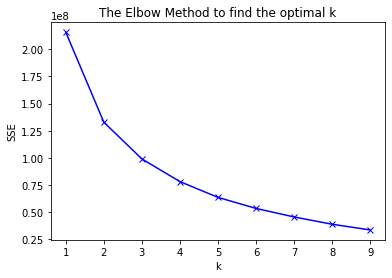

In [50]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(train)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [51]:
X = train

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[ 2.13719450e-02  6.03700495e+03  5.21380678e+01  1.58941019e+01
   4.45942510e-01  5.38957824e-01  5.53285592e-01  4.06020027e-01
   4.74706268e-01  4.48294527e-01  4.94545823e-01  3.05257966e-01
   2.91381834e-01  3.14353336e-01  2.94780778e-01  8.27090795e-02
   2.24971878e-04]
 [ 1.00224464e-02  6.03700188e+03  1.12856559e+02  4.37998708e+01
   3.99864306e-01  5.27232237e-01  5.12684767e-01  5.17926712e-01
   5.22353697e-01  5.32526760e-01  5.16797209e-01  6.63534137e-01
   6.68768715e-01  6.42303987e-01  6.65829221e-01  6.48906528e-02
   8.83514230e-01]
 [-8.54922908e-03  6.03700000e+03  5.24123840e+02  2.17480133e+02
   3.98153058e-01  4.74593829e-01  3.60089451e-01  6.96094217e-01
   6.08604336e-01  7.17189922e-01  6.13671881e-01  9.77807694e-01
   9.76299658e-01  9.60073637e-01  9.70870742e-01  1.58543180e-01
   2.11585366e+00]
 [ 1.42397474e-02  6.03738596e+03  2.77097443e+02  8.42879633e+02
   2.93668955e-01  3.90696381e-01  3.71535323e-01  8.04827726e-01
   5.94364700e-01  

target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0        13347.0  0.021347  0.174123 -2.271428 -0.030331  0.006806  0.045255   
1        11689.0  0.010039  0.151265 -4.655420 -0.026543  0.005181  0.036711   
2          164.0 -0.008549  0.333762 -2.175696 -0.051755  0.024116  0.075334   
3           57.0  0.014240  0.157799 -0.430161 -0.054102  0.018603  0.074126   
4         1655.0  0.004744  0.207874 -0.976064 -0.038788  0.008217  0.050609   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.100913  13347.0  6037.004945  ...   0.427741  0.973109   
1        3.394544  11689.0  6037.001882  ...   0.819334  0.991486   
2        2.069414    164.0  6037.000000  ...   0.990735  0.999529   
3        0.664921     57.0  6037.385965  ...   0.991075  1.000000   
4        5.262999   1655.0  6037.000000  ...   0.972301  0.997639   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0               13347.0  0.082669  0.154725  0.000003  0.016301  0.037919   
1               11689.0  0.064918  0.136993  0.000011  0.014241  0.032305   
2                 164.0  0.158543  0.293565  0.000161  0.033916  0.065791   
3                  57.0  0.103462  0.119212  0.003005  0.034994  0.071972   
4                1655.0  0.087113  0.188787  0.000007  0.020774  0.046093   

                             
              75%       max  
cluster                      
0        0.085804  3.100913  
1        0.067988  4.655420  
2        0.143942  2.175696  
3        0.125925  0.664921  
4        0.092876  5.262999  

[5 rows x 128 columns]

In [52]:
X = train

kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(kmeans.cluster_centers_)

train['cluster'] = kmeans.labels_

train.groupby('cluster').describe()

[[ 2.33566673e-02  6.03700231e+03  4.26947203e+01  1.17271608e+01
   4.63542622e-01  5.27175762e-01  5.49404726e-01  3.83527318e-01
   4.61289860e-01  4.34136158e-01  4.86299698e-01  2.35417438e-01
   2.20199580e-01  2.51304320e-01  2.24029724e-01  8.89849574e-02
   1.10578213e-13]
 [ 8.02047370e-03  6.03700000e+03  1.89982997e+02  2.30915402e+02
   4.40657350e-01  4.49819957e-01  4.10831534e-01  6.51439566e-01
   5.46113516e-01  6.69991417e-01  3.29659541e-01  8.45941007e-01
   9.35073743e-01  9.45265004e-01  9.30302919e-01  8.69260206e-02
   3.96428571e+00]
 [-1.04148339e-02  6.03700000e+03  5.35406183e+02  2.08151316e+02
   3.95445135e-01  4.75691129e-01  3.62735834e-01  6.93118570e-01
   5.98701299e-01  7.15472586e-01  6.23895216e-01  9.78670830e-01
   9.75174899e-01  9.56192832e-01  9.69375265e-01  1.63299456e-01
   2.01298701e+00]
 [ 2.05588144e-02  6.03746809e+03  2.91905417e+02  9.07539243e+02
   3.04347826e-01  3.97788410e-01  3.48436959e-01  8.08096159e-01
   6.03374167e-01  

target                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0         9527.0  0.023340  0.184630 -2.271428 -0.032089  0.007869  0.049267   
1          840.0  0.008020  0.228864 -0.860147 -0.034724  0.013346  0.054631   
2          154.0 -0.010415  0.343415 -2.175696 -0.052218  0.021616  0.073917   
3           47.0  0.020559  0.156524 -0.430161 -0.049346  0.018603  0.068481   
4         3456.0  0.002998  0.157242 -1.738639 -0.034092  0.005629  0.043585   
5        12888.0  0.013246  0.149901 -4.655420 -0.025982  0.004898  0.036008   

                      fips               ... tax_amount            \
              max    count         mean  ...        75%       max   
cluster                                  ...                        
0        3.100913   9527.0  6037.002309  ...   0.316913  0.973109   
1        5.262999    840.0  6037.000000  ...   0.977474  0.997639   
2        2.069414    154.0  6037.000000  ...   0.990768  0.999529   
3        0.664921     47.0  6037.468085  ...   0.991281  1.000000   
4        2.591723   3456.0  6037.000000  ...   0.931802  0.993276   
5        3.394544  12888.0  6037.005121  ...   0.736755  0.991486   

        absolute_target                                                    \
                  count      mean       std       min       25%       50%   
cluster                                                                     
0                9527.0  0.088989  0.163441  0.000003  0.017541  0.040915   
1                 840.0  0.086926  0.211844  0.000034  0.022389  0.045502   
2                 154.0  0.163299  0.301997  0.000429  0.034353  0.065532   
3                  47.0  0.100157  0.121169  0.006578  0.033686  0.064991   
4                3456.0  0.076036  0.137662  0.000007  0.016637  0.038807   
5               12888.0  0.063999  0.136197  0.000006  0.013761  0.031552   

                             
              75%       max  
cluster                      
0        0.093389  3.100913  
1        0.089418  5.262999  
2        0.145386  2.175696  
3        0.121277  0.664921  
4        0.081880  2.591723  
5        0.066106  4.655420  

[6 rows x 128 columns]

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt

def regression_errors(y, yhat, data_frame):
    # SSE - sum of squared errors using MSE * len()
    SSE = mean_squared_error(y, X_train.yhat) * len(X_train)
    # MSE - mean of squared errors
    MSE = mean_squared_error(y, X_train.yhat)
    # ESS - explained sum of squares
    ESS = sum((X_train.yhat - train.target.mean()) ** 2)
    # TSS - total sum of squares
    TSS = SSE + ESS
    # RMSE - root mean squared error
    RMSE = sqrt(MSE)
    print("SSE: ", SSE, "EES: ", ESS, "TSS: ", TSS, "MSE: ", MSE, "RMSE: ", RMSE)
    return SSE, ESS, TSS, MSE, RMSE

In [53]:
# Create linear model
X_train = pd.DataFrame(train.drop(columns='target'))
y_train = pd.DataFrame(train.target)

In [125]:
# Baseline Everything
x = pd.DataFrame(train.drop(columns=['target','absolute_target']))
y = pd.DataFrame(train.target)

regr = ols('y ~ x', data = train).fit()

X_train['yhat'] = regr.predict(x)

regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.130
Date:                Thu, 07 Nov 2019   Prob (F-statistic):           6.71e-16
Time:                        17:21:45   Log-Likelihood:                 9790.7
No. Observations:               26912   AIC:                        -1.955e+04
Df Residuals:                   26896   BIC:                        -1.942e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4886     20.694      0.120      0.904     -38.073      43.050
x[0]          -0.0004      0.003     -0.119      0.905      -0.007       0.006
x[1]       -7.366e-05   2.88e-05     -2.560      0.010      -0.000   -1.73e-05
x[2]        1.698e-05   2.34e-05      0.727      0.467   -2.88e-05    6.28e-05
x[3]          -0.0210      0.008     -2.493      0.013      -0.038      -0.004
x[4]          -0.0162      0.009     -1.876      0.061      -0.033       0.001
x[5]           0.0125      0.006      2.003      0.045       0.000       0.025
x[6]           0.0106      0.006      1.716      0.086      -0.002       0.023
x[7]           0.0160      0.005      2.993      0.003       0.006       0.026
x[8]          -0.0004      0.009     -0.044      0.965      -0.017       0.017
x[9]           0.0088      0.005      1.878      0.060      -0.000       0.018
x[10]         -0.0057      0.015     -0.389      0.697      -0.034       0.023
x[11]          0.0012      0.035      0.034      0.973      -0.068       0.071
x[12]          0.0161      0.023      0.712      0.476      -0.028       0.060
x[13]         -0.0278      0.019     -1.456      0.145      -0.065       0.010
x[14]         -0.0008      0.001     -1.163      0.245      -0.002       0.001
==============================================================================
Omnibus:                    27369.236   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         18172215.322
Skew:                           4.193   Prob(JB):                         0.00
Kurtosis:                     130.026   Cond. No.                     1.22e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [122]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  761.156200648913 EES:  3.0268153793811186 TSS:  764.1830160282941 MSE:  0.028283152521139752 RMSE:  0.16817595702459895


In [120]:
# Baseline Everything except 'home_value_square_footage', 'land_value_square_footage'
x = pd.DataFrame(X_train.drop(columns = ['home_value_square_footage', 'land_value_square_footage', 'absolute_target']))
y = pd.DataFrame(train.target) 

regr = ols('y ~ x', data = train).fit()
X_train['yhat'] = regr.predict(x)

#regr.summary()

In [112]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  761.1783130357134 EES:  3.004702992580557 TSS:  764.1830160282939 MSE:  0.028283974176416222 RMSE:  0.16817839985092087


In [119]:
# Baseline Everything including 'home_value_square_footage', 'land_value_square_footage'
# Except removing 4 columns that calulated: columns = 'home_value_square_footage', 'land_value_square_footage'
x = pd.DataFrame(X_train.drop(columns = ['structure_value', 'lot_square_feet', 'home_square_feet', 'land_value','absolute_target']))
y = pd.DataFrame(train.target) 

regr = ols('y ~ x', data = train).fit()
X_train['yhat'] = regr.predict(x)

#regr.summary()

In [115]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  761.1597110631965 EES:  3.023304965097554 TSS:  764.183016028294 MSE:  0.028283282961622937 RMSE:  0.16817634483369812


In [117]:
# Baseline of only created features: 'home_value_square_footage', 'land_value_square_footage')
x = X_train[['home_value_square_footage', 'land_value_square_footage']]
y = pd.DataFrame(train.target) 

regr = ols('y ~ x', data = train).fit()
X_train['yhat'] = regr.predict(x)

#regr.summary()

In [118]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  763.1119266130522 EES:  1.071089415241757 TSS:  764.183016028294 MSE:  0.028355823670223403 RMSE:  0.16839187530942046


**Absolute**

In [127]:
# Baseline Everything
x = pd.DataFrame(train.drop(columns=['target','absolute_target']))
y = pd.DataFrame(train.absolute_target)

regr = ols('y ~ x', data = train).fit()

X_train['yhat'] = regr.predict(x)

#regr.summary()

In [128]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  604.2950778636837 EES:  110.3173738150914 TSS:  714.6124516787751 MSE:  0.02245448416556494 RMSE:  0.1498482037448729


In [129]:
# Baseline Everything except 'home_value_square_footage', 'land_value_square_footage'
x = pd.DataFrame(X_train.drop(columns = ['home_value_square_footage', 'land_value_square_footage', 'absolute_target']))
y = pd.DataFrame(train.target) 

regr = ols('y ~ x', data = train).fit()
X_train['yhat'] = regr.predict(x)

#regr.summary()

In [130]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y, X_train.yhat, train)

SSE:  761.2206177150567 EES:  2.9623983132371614 TSS:  764.1830160282939 MSE:  0.028285546139828206 RMSE:  0.16818307328571508
